# Bioinformatics Final Project 
## Predicting Breast Cancer Treatment Outcome using Machine Learning on Mutation Profiles

A. Ali Heydari

## Abstract

Cancer patients have one of the highest mortality rates of all diseases, and cancer diagnosis and prognosis remain a highly challenging task. According to the National Cancer Institute, breast cancer is the most common cancer type, but the effectiveness of treatment for cancer patients remains largely unknown. For decades, researchers have studied various ways to improve the prognosis of cancers, and machine learning has been at the forefront of that effort in the recent years. Many machine learning models can predict breast cancer with high accuracy, but very few have studied the effect of prognosis, and very few have considered the patients' mutation profiles alone. 

# Introduction

In this section, we will discuss the problem at hand and some related work in **Background**. In the **Data Analysis**, we will explore the data to see what types of mutations are present and what are some of the most mutated genes. In the same section, we will also work through how to split the data to *Train, Validate and Test* so that the distribution of the data is the same in all three sub-divisions (for more accurate training). The ***Methods*** section will walk us through the architecture of our networks and training and Gene Set Enrichment Analysis (GSEA). Lastly, ***Results and Discussion*** will focus on the results of our training and GSEA and what should be interpreted from it, and future direction of this research.

### Background and Data Analysis

Our data is the Breast Cancer data from TCGA (***TCGA-BRCA***) available [here](https://portal.gdc.cancer.gov/projects/TCGA-BRCA) (as of Dec. 14th 2019). The data format is *Mutation Annotated File (maf)*, and we can use a <code> maftools </code> (available [here](https://bioconductor.org/packages/release/bioc/html/maftools.html)) to explore the data. First, we want to install <code> maftools </code> through R. There is a full R-Notebook available at [My Github](https://github.com/dr-aheydari/Breast-Cancer-Treatment-Prediction).

# Data Proceesing for Training
In this section we will read in the data, look at the label distribution and bootstrap the minority class. We use the data prepared in the <code> R </code> and other <code> Python </code> notebook to process and preapre for training.

Now that we have the data as samples vs. Genes, we want to load the data in; we have splitted the data in three categories (train, validation and test) but later we will reunite them and split it one more time

## Install Needed Packages
Here we include a script to install all needed packages for this notebook. Please be advised that there might be some packages that we may have forgotten to include, and/or they are included on this pod that may not be on your machine. Please read the errors carefully and install any additional packages as needed. Please uncomment any/all package you need on your machine.

In [1]:
# ! pip install numpy
# ! pip install pandas
# ! pip install tensorflow==1.14
# ! pip install tensorflow_gpu==1.14
# ! pip install -U scikit-learn
# ! pip install imblearn
# ! pip install matplotlib
# ! pip install torch torchvision
# ! pip install gseapy

In [2]:
import os
import numpy as np
import pandas as pd

# read the data
# PLEASE MAKE SURE TO CHANGE THE DIRECTORY TO YOUR LOCAL DIRECTORY
train_data = open("/home/jovyan/NRT ICGE/train_matrix.tsv", "r+");
valid_data = open("/home/jovyan/NRT ICGE/val_matrix.tsv", "r+");
test_data = open("/home/jovyan/NRT ICGE/test_matrix.tsv", "r+");

train_resp_data = open("/home/jovyan/NRT ICGE/train_response.tsv", "r+");
valid_resp_data = open("/home/jovyan/NRT ICGE/val_response.tsv", "r+");
test_resp_data = open("/home/jovyan/NRT ICGE/test_response.tsv", "r+");

# init the NUMPY arrays (later need tensors)
train = [];
tr_resp = [];

valid = [];
val_resp = [];

test = [];
tst_resp = [];
labels = [];

# use pandas to read the data and get rid of tabs
tr_df = pd.read_csv(train_data, sep="\t");
vl_df = pd.read_csv(valid_data, sep="\t");
ts_df = pd.read_csv(test_data, sep="\t");


Now to get the gene names, which will come in handy later for feature importance. We get the gene names as an array which we can iterate through : 

In [3]:
### to get the column names which are the gene names : 
genes = pd.read_csv("/home/jovyan/NRT ICGE/train_matrix.tsv",sep="\t", nrows=1).columns.tolist()

Now we can put the three splits of our data into different numpy arrays that we can use for training. We also get rid of our responses in the data to make sure we are not providing the ansewers to our models:

In [4]:
"""
NOTE: to use the code below, make sure to add the column headers to
the treatment response tsv file : )

"""
## we only need second column because second column has the 0 and 1 ##
# training
tr_rs_df = pd.read_csv(train_resp_data, sep="\t",na_values=' ');
tr_rs_df = tr_rs_df["COL2"];

# validation
vl_rs_df = pd.read_csv(valid_resp_data, sep="\t");
vl_rs_df = vl_rs_df["COL2"];

# test

ts_rs_df = pd.read_csv(test_resp_data, sep="\t");
ts_rs_df = ts_rs_df["COL2"];


# get only the numerical values of the arrays
train = tr_df.values;
valid = vl_df.values;
test = ts_df.values;

# responses
train_resp = tr_rs_df.values;
valid_resp = vl_rs_df.values;
test_resp = ts_rs_df.values;


# get rid of the patient responses at the last column (usually used in random forests)

print("last column of Train")
print(train[:,-1])


if train[:,0:-1].all() == train_resp.all() :
    print("removing responses from the matrix")
    train_new = train[:,0:-1];
else :
    train_new = train;
    #args.input_size

print("Most recent Train's LC :")

print(train_new[:,-1])

print("last column of Validation")
print(valid[:,-1])

if valid[:,0:-1].all() == valid_resp.all() :
    print("removing responses from the matrix")
    valid_new = valid[:,0:-1];
else:
    valid_new = valid;
# LC means last column
print("Most recent validation's LC :")
print(valid_new[:,-1])


print("last column of Test")
print(test[:,-1])

if test[:,0:-1].all() == test_resp.all():
    print("removing responses from the matrix")
    test_new = test[:,0:-1];

else:
    test_new = test;
print("Most recent validation's LC :")
print(test_new[:,-1])

last column of Train
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
removing responses from the matrix
Most recent Train's LC :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Now we put the data back into one big array to perform upsampling and have ***Sci-Kit Learn*** split it for us later into test and train (since we have such a small dataset).

In [5]:
train_test = np.vstack((train_new, test_new))
all_data = np.vstack((train_test,valid_new));   
# to make sure we have the correct dimension of 987x19162
print(all_data.shape)
tt_resp = np.hstack((train_resp,test_resp));
all_resp = np.hstack((tt_resp,valid_resp));
# to make sure we have the correct dimension of 1x987
print(all_resp.shape)

(987, 19162)
(987,)


## Upsampling with Replacement the Minority Class in Patients 
We will show the count of the responses in the code below; we have many more patients labeled as responsiveness than unresponsiveness, therefore we will get very skewed classifications. To combat this issue, we use Sci-kit Learn's bootstrapping algorithm to upsample the minority class

In [6]:
from sklearn.utils import resample

# EXPLANATION ON WHY USING SO MANY FOR LOOPS
# get a count of the minority and majority
# this is the most efficient way of making a dynamic matrix in numpy
# this is becuase NumPy arrays are stored in contiguous blocks of memory. If you want to add rows or columns to an existing array
#the entire array needs to be copied to a new block of memory, creating gaps for the new elements to be stored. 
#This is very inefficient if done repeatedly to build an array (specially that we are running this on a cluster with 48 cores).

# unresponive counter
count = 0;
# responsive counter
bount = 0;
for i in range(len(all_resp)):
    # check to see if response is 0
    if all_resp[i] == 0:    
        count += 1;        
    if all_resp[i] == 1:
        bount += 1;
print("Number of Unresponsive Patients: {}".format(count))
print("Number of Responsive Patients: {}".format(bount))
        
# initializing the majority and minority    arrays     
majority = np.zeros(shape=(bount,19162))
minority = np.zeros(shape=(count,19162))

# counters
count = 0;
bount = 0;

for i in range(len(all_resp)):
    # check to see if response is 0
    if all_resp[i] == 0:    
        minority[count,:] = all_data[i,:];
        count += 1;
        
    if all_resp[i] == 1:
        majority[bount,:] = all_data[i,:];
        bount += 1;
 
# Upsample minority class using bootstrapping
minority_upsampled = resample(minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=580,    # to match majority class
                                 random_state=123) # reproducible results

#initialize the labels 
minor_labels = np.zeros((580,))
major_labels = np.ones((588,))
# Combine majority class with upsampled minority class
upsampled = np.empty(shape=(len(minority_upsampled) + len(majority),19162));
# stack up the minority and the majority samples again
upsampled = np.vstack([majority, minority_upsampled])
 
print("After Bootstrapping we now have a total data size of: {}".format(upsampled.shape))

# stacking the labels back with one another
upsampled_labels = np.hstack((major_labels,minor_labels))

#
print("After Bootstrapping we also have {} labels".format(upsampled.shape))

Number of Unresponsive Patients: 399
Number of Responsive Patients: 588
After Bootstrapping we now have a total data size of: (1168, 19162)
After Bootstrapping we also have (1168, 19162) labels


we will shuffle the rows of the data now, since we just stacked the data on top of each other

In [7]:
from sklearn.utils import shuffle
# shuffle
upsampled, upsampled_labels = shuffle(upsampled, upsampled_labels, random_state=7)

## Selecting Fewer Features to Reduce Complexity
Using <code> maftools </code> we found that the median number of mutations per gene are 41, so we will eliminate genes that have been mutated in less than 30 patients (in less than 3% of our patients). This will help us reduce the feature space and perhaps learn more valuable information

In [8]:
#sum the rows to get the most important factors with highest mutations
row_sums = all_data.sum(axis=0)
ind=np.array(1);
count=0;
for i in range(len(row_sums)):
    if row_sums[i] > 30:
        count+=1;
#         print("Keep columns: {}".format(i))
        ind = np.append(ind,i);
        
        
print("The new size of our feature space is {}".format(ind.shape))

The new size of our feature space is (163,)


Now we will filter out these genes from the patient's data : 

In [9]:
#filtering the upsampled data
filtered_all = np.take(upsampled, ind, 1);

# filtering the original data
all_data_filtered = np.take(all_data, ind, 1);
print("Shape of the new upsampled data: {}".format(filtered_all.shape)) 
print("Shape of the original data {}".format(all_data_filtered.shape))

Shape of the new upsampled data: (1168, 163)
Shape of the original data (987, 163)


## Upsampling Minority with SMOTE
In this section we will upsample our data using SMOTE.

In [10]:
from imblearn.over_sampling import SMOTE

# load in the original data
X = all_data;
y = all_resp;

# upsample in parallel
sm = SMOTE(sampling_strategy='minority', random_state=22, k_neighbors=3, n_jobs=-1)

X_smote,y_smote = sm.fit_resample(X, y)

print("The New Upsampled data dimensions: {}".format(X_smote.shape))
print("The shape of the new upsampled response: {}".format(y_smote.shape))



Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

The New Upsampled data dimensions: (1176, 19162)
The shape of the new upsampled response: (1176,)


Now to reduce the gene space for the mutations in more than 3% of the patients :

In [11]:
filtered_smote = np.take(X_smote, ind, 1);
print("Shape of the new upsampled data with SMOTE: {}".format(filtered_smote.shape)) 

Shape of the new upsampled data with SMOTE: (1176, 163)


# Training the Machine Learning Models
First we want to train a Gradient Boosted Decision Tree, or more specifically, we will be using the eXtreme Gradient Boosting algorithm (XGBoost). More information about the algorithm can be found [here](https://). First, we want to do some parameter tuning using Cross Validation and grid search. 


## Fully Connected Neural Networks
We want to train a classifier that would classify the patients' responsiveness to treatment, based on the mutation profile. We have tested many many different structures and, so far, the below structure is one of the best performing ones.

In [12]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
#our class must extend nn.Module


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if str(device) == "cuda":
    print('Available to train on GPU')
else:
    print('Can train on CPU only')


class MyClassifier(nn.Module):
    def __init__(self):
        super(MyClassifier,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(163,32)        
        #This applies linear transformation to produce output data
        self.fc2 = nn.Linear(32,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,256)
        self.fc5 = nn.Linear(256,16)
        self.fc6 = nn.Linear(16,2)
        self.relu = nn.ReLU();
        # if needed
        self.dropout = nn.Dropout(0.25)
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x);
        x = self.relu(x);
        
        x = self.fc2(x);
        x = self.relu(x);
#         x= self.dropout(x);
            
        x = self.fc3(x);
        #x = self.relu(x);
        x = self.relu(x);
#         x= self.dropout(x);
        
        x = self.fc4(x);
        x = self.relu(x);
        
        x = self.fc5(x);
        x = self.relu(x);
        
        x = self.fc6(x);

#       x = torch.tanh(x)
        return F.log_softmax(x)

    #This function takes an input and predicts the class, (0 or 1)        
    def predict(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x))
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

Available to train on GPU


In [13]:
#Initialize the model and send to CUDA       
model = MyClassifier().to(device)
#Define loss criterion and send to CUDA
criterion = nn.CrossEntropyLoss().to(device)
#Define the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Training on Upsampled with Replacement 

In [14]:
#!/usr/bin/env python -W ignore::DeprecationWarning

# to split the train-test data
from sklearn.model_selection import train_test_split

X = filtered_all;
y = upsampled_labels;

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 1, stratify=y)

X = torch.from_numpy(X_train).type(torch.FloatTensor)
y = torch.from_numpy(y_train).type(torch.LongTensor)

X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

#Number of epochs
epochs = 65
#List to store losses
losses = []
batch_size = 32;
counter = 0;
for i in range(epochs):
    counter += 1;
    #Precit the output for Given input
    y_pred = model.forward(X.to(device))
    #Compute Cross entropy loss
    loss = criterion(y_pred,y.to(device))
    #Add loss to the list
    losses.append(loss.item())
    #Clear the previous gradients
    optimizer.zero_grad()
    #Compute gradients
    loss.backward()
    #Adjust weights
    optimizer.step()
    counter += 1;
    if counter % 10 == 0:
            temp = loss.data;
            print('Epoch [%d/%d],Cross Entropy Loss: %.4f'
                 %(i+1, epochs, loss.data))
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [5/65],Cross Entropy Loss: 0.6834
Epoch [10/65],Cross Entropy Loss: 0.5533
Epoch [15/65],Cross Entropy Loss: 0.3544
Epoch [20/65],Cross Entropy Loss: 0.2023
Epoch [25/65],Cross Entropy Loss: 0.0830
Epoch [30/65],Cross Entropy Loss: 0.0392
Epoch [35/65],Cross Entropy Loss: 0.0204
Epoch [40/65],Cross Entropy Loss: 0.0130
Epoch [45/65],Cross Entropy Loss: 0.0130
Epoch [50/65],Cross Entropy Loss: 0.0120
Epoch [55/65],Cross Entropy Loss: 0.0120
Epoch [60/65],Cross Entropy Loss: 0.0126
Epoch [65/65],Cross Entropy Loss: 0.0129


In [15]:
# to get the accuracy score and AUC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


print("Accuracy Score (Correct pred./all pred.): {}".format(accuracy_score((model.predict(X_test.to(device))),y_test)))
print("AUC of ROC: {}".format(roc_auc_score(y_test, model.predict(X_test.to(device)))))

Accuracy Score (Correct pred./all pred.): 0.7222222222222222
AUC of ROC: 0.723188194038574


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### Training on Upsampled with SMOTE

In [16]:
#!/usr/bin/env python -W ignore::DeprecationWarning

# to split the train-test data
from sklearn.model_selection import train_test_split

X = filtered_smote;
y = y_smote;

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 1, stratify=y)

X = torch.from_numpy(X_train).type(torch.FloatTensor)
y = torch.from_numpy(y_train).type(torch.LongTensor)

X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

#Number of epochs
epochs = 65
#List to store losses
losses = []
counter = 0;
for i in range(epochs):
    counter += 1;
    #Precit the output for Given input
    y_pred = model.forward(X.to(device))
    #Compute Cross entropy loss
    loss = criterion(y_pred,y.to(device))
    #Add loss to the list
    losses.append(loss.item())
    #Clear the previous gradients
    optimizer.zero_grad()
    #Compute gradients
    loss.backward()
    #Adjust weights
    optimizer.step()
    counter += 1;
    if counter % 10 == 0:
            temp = loss.data;
            print('Epoch [%d/%d],Cross Entropy Loss: %.4f'
                 %(i+1, epochs, loss.data))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [5/65],Cross Entropy Loss: 0.2800
Epoch [10/65],Cross Entropy Loss: 0.4406
Epoch [15/65],Cross Entropy Loss: 0.3617
Epoch [20/65],Cross Entropy Loss: 0.2583
Epoch [25/65],Cross Entropy Loss: 0.1448
Epoch [30/65],Cross Entropy Loss: 0.1019
Epoch [35/65],Cross Entropy Loss: 0.0791
Epoch [40/65],Cross Entropy Loss: 0.0605
Epoch [45/65],Cross Entropy Loss: 0.0523
Epoch [50/65],Cross Entropy Loss: 0.0473
Epoch [55/65],Cross Entropy Loss: 0.0440
Epoch [60/65],Cross Entropy Loss: 0.0426
Epoch [65/65],Cross Entropy Loss: 0.0417


In [17]:
# to get the accuracy score and AUC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


print("Accuracy Score (Correct pred./all pred.): {}".format(accuracy_score((model.predict(X_test.to(device))),y_test)))
print("AUC of ROC: {}".format(roc_auc_score(y_test, model.predict(X_test.to(device)))))

Accuracy Score (Correct pred./all pred.): 0.7415254237288136
AUC of ROC: 0.7415254237288135


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Training with SciKit Learn Fully Connected Nerual Nets
First on the upsampled data with replacement

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

X = upsampled;
y = upsampled_labels;

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True, random_state=22)

clf = MLPClassifier(hidden_layer_sizes=(32,128,64,256,32), activation='relu', solver='adam', alpha=0.000001, batch_size=32, learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, max_iter=10, 
                                  shuffle=True, random_state=22, tol=0.0001, verbose=1, warm_start=False, momentum=0.0, 
                                  nesterovs_momentum=True, early_stopping=True, validation_fraction=0.2, beta_1=0.9, beta_2=0.999, 
                                  epsilon=1e-08, n_iter_no_change=5, max_fun=500000);

print(clf)

clf.fit(X_train, y_train)
score = metrics.accuracy_score(y_test, clf.predict(X_test))
print(score)
print(clf.predict(X_test))
print(y_test)

MLPClassifier(activation='relu', alpha=1e-06, batch_size=32, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(32, 128, 64, 256, 32),
              learning_rate='adaptive', learning_rate_init=0.001,
              max_fun=500000, max_iter=10, momentum=0.0, n_iter_no_change=5,
              nesterovs_momentum=True, power_t=0.5, random_state=22,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.2,
              verbose=1, warm_start=False)
Iteration 1, loss = 0.68829654
Validation score: 0.716578
Iteration 2, loss = 0.31891878
Validation score: 0.786096
Iteration 3, loss = 0.01021935
Validation score: 0.823529
Iteration 4, loss = 0.00132622
Validation score: 0.834225
Iteration 5, loss = 0.00049069
Validation score: 0.834225
Iteration 6, loss = 0.00032873
Validation score: 0.834225
Iteration 7, loss = 0.00020618
Validation score: 0.834225
Iteration 8, loss = 0.00016993
Validation score: 0.834225
Iterati

In [113]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix


# make predictions for test data
y_pred = clf.predict(X_train)
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_pred))


# make predictions for test data
y_pred = clf.predict(X_test)
print("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Number true positive: " + str(tp))
print("Number true negative: " + str(tn))
print("Number false positive: " + str(fp))
print("Number false negative: " + str(fn))

AUC Score (Train): 0.966609
AUC Score (Test): 0.806473
Number true positive: 112
Number true negative: 77
Number false positive: 39
Number false negative: 6


### Training with the SMOTE Upsampled Data

In [19]:
X = X_smote;
y = y_smote;

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True, random_state=22)

clf = MLPClassifier(hidden_layer_sizes=(32,128,64,256,32), activation='relu', solver='adam', alpha=0.000001, batch_size=32, learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, max_iter=10, 
                                  shuffle=True, random_state=22, tol=0.0001, verbose=1, warm_start=False, momentum=0.0, 
                                  nesterovs_momentum=True, early_stopping=True, validation_fraction=0.2, beta_1=0.9, beta_2=0.999, 
                                  epsilon=1e-08, n_iter_no_change=5, max_fun=500000);

clf.fit(X_train, y_train)
score = metrics.accuracy_score(y_test, clf.predict(X_test))
print(score)
print(clf.predict(X_test))
print(y_test)

Iteration 1, loss = 0.69367620
Validation score: 0.654255
Iteration 2, loss = 0.52369542
Validation score: 0.632979
Iteration 3, loss = 0.10990368
Validation score: 0.691489
Iteration 4, loss = 0.01360342
Validation score: 0.686170
Iteration 5, loss = 0.00641753
Validation score: 0.686170
Iteration 6, loss = 0.00243325
Validation score: 0.686170
Iteration 7, loss = 0.00112260
Validation score: 0.691489
Iteration 8, loss = 0.00057759
Validation score: 0.680851
Iteration 9, loss = 0.00037391
Validation score: 0.686170
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
0.635593220338983
[1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0
 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0
 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1
 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1
 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0

In [20]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix


# make predictions for test data
y_pred = clf.predict(X_train)
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_pred))


# make predictions for test data
y_pred = clf.predict(X_test)
print("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Number true positive: " + str(tp))
print("Number true negative: " + str(tn))
print("Number false positive: " + str(fp))
print("Number false negative: " + str(fn))

print("AUC of ROC: {}".format(roc_auc_score(y_pred,y_test)))


AUC Score (Train): 0.935106
AUC Score (Test): 0.635593
Number true positive: 85
Number true negative: 65
Number false positive: 53
Number false negative: 33
AUC of ROC: 0.639603667553978


### Train on the Original Data (Not Upsampled)

In [21]:
# shuffle the data first

X, y = shuffle(all_data_filtered, all_resp, random_state=7)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True, random_state=22)

clf = MLPClassifier(hidden_layer_sizes=(32,128,64,256,32), activation='relu', solver='adam', alpha=0.000001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, max_iter=10, 
                                  shuffle=True, random_state=22, tol=0.0001, verbose=1, warm_start=False, momentum=0.0, 
                                  nesterovs_momentum=True, early_stopping=True, validation_fraction=0.2, beta_1=0.9, beta_2=0.999, 
                                  epsilon=1e-08, n_iter_no_change=5, max_fun=500000);

clf.fit(X_train, y_train)
score = metrics.accuracy_score(y_test, clf.predict(X_test))
print(score)
print(clf.predict(X_test))
print(y_test)

Iteration 1, loss = 0.68711115
Validation score: 0.594937
Iteration 2, loss = 0.67427892
Validation score: 0.594937
Iteration 3, loss = 0.67402866
Validation score: 0.594937
Iteration 4, loss = 0.66787755
Validation score: 0.594937
Iteration 5, loss = 0.66443183
Validation score: 0.594937
Iteration 6, loss = 0.66003583
Validation score: 0.594937
Iteration 7, loss = 0.65500547
Validation score: 0.594937
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
0.5959595959595959
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0
 1 0 

In [22]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix


# make predictions for test data
y_pred = clf.predict(X_train)
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_pred))


# make predictions for test data
y_pred = clf.predict(X_test)
print("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Number true positive: " + str(tp))
print("Number true negative: " + str(tn))
print("Number false positive: " + str(fp))
print("Number false negative: " + str(fn))

AUC Score (Train): 0.500000
AUC Score (Test): 0.500000
Number true positive: 118
Number true negative: 0
Number false positive: 80
Number false negative: 0


As we can see, the upsampling with replacement performs better than SMOTE. As expected and as discussed in the paper, when we do not upsample the minority class the NN is encouraged to guess everyone as responsive, hence having a surge of false positives. This is particularly true in NN and may not be as bad in other machine learning techniques.

## Training Gradient Boosted Decision Trees

Below we have an implementation for XGBoost Decision Tree Ensembles both with the original data with 163 features, and the bootsrapped data. 

### Original Data with 163 Genes

In [23]:
from xgboost import XGBClassifier
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X = all_data_filtered;
Y = all_resp;

seed = 7;
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
X_train, y_train = filtered_all, upsampled_labels

model_OG = XGBClassifier(
 n_estimators=300,
 # this is supposed to be 1 for Random Forests
 learning_rate =1,
 min_child_weight=1.0,
 gamma=0,
 subsample=.9,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=1.0,
 seed=27,
 verbosity=1)

model_OG.fit(X_train,y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=1, max_delta_step=0, max_depth=3,
              min_child_weight=1.0, missing=None, n_estimators=300, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0, seed=27,
              silent=None, subsample=0.9, verbosity=1)

In [24]:
# Once the best model is chosen, test data is run on the model
y_pred = model_OG.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Number true positive: " + str(tp))
print("Number true negative: " + str(tn))
print("Number false positive: " + str(fp))
print("Number false negative: " + str(fn))

Number true positive: 171
Number true negative: 95
Number false positive: 20
Number false negative: 11


In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

print("On the original data set (not Upsampled)")
print("Accuracy Score (Correct pred./all pred.): {}".format(accuracy_score(y_pred,y_test)))
print("AUC of ROC: {}".format(roc_auc_score(y_pred,y_test)))

On the original data set (not Upsampled)
Accuracy Score (Correct pred./all pred.): 0.8956228956228957
AUC of ROC: 0.8957571866047616


### With Upsampled Data and 163 Genes

In [26]:
from xgboost import XGBClassifier
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X = filtered_all;
Y = upsampled_labels;

seed = 7;
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
X_train, y_train = filtered_all, upsampled_labels

model_up = XGBClassifier(
 n_estimators=300,
 learning_rate =1,
 min_child_weight=1.0,
 gamma=0,
 subsample=.9,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=1.0,
 seed=27,
 verbosity=1)

model_up.fit(X_train,y_train)




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=1, max_delta_step=0, max_depth=3,
              min_child_weight=1.0, missing=None, n_estimators=300, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0, seed=27,
              silent=None, subsample=0.9, verbosity=1)

In [27]:
# Once the best model is chosen, test data is run on the model
y_pred = model_up.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Number true positive: " + str(tp))
print("Number true negative: " + str(tn))
print("Number false positive: " + str(fp))
print("Number false negative: " + str(fn))

Number true positive: 176
Number true negative: 166
Number false positive: 5
Number false negative: 4


In [28]:
print("On the upsampled (bootsrapped) data")
print("Accuracy Score (Correct pred./all pred.): {}".format(accuracy_score(y_pred,y_test)))
print("AUC of ROC: {}".format(roc_auc_score(y_pred,y_test)))

On the upsampled (bootsrapped) data
Accuracy Score (Correct pred./all pred.): 0.9743589743589743
AUC of ROC: 0.9744231394215144


### Upsampled with SMOTE 

In [29]:
X = X_smote;
Y = y_smote;

seed = 7;
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
X_train, y_train = X_smote,y_smote;

model_smote = XGBClassifier(
 n_estimators=300,
 learning_rate =0.01,
 min_child_weight=1.0,
 gamma=0,
 subsample=.99,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=1.0,
 seed=27,
 verbosity=1)

model_smote.fit(X_train,y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1.0, missing=None, n_estimators=300, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0, seed=27,
              silent=None, subsample=0.99, verbosity=1)

In [30]:
# Once the best model is chosen, test data is run on the model
y_pred = model_smote.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Number true positive: " + str(tp))
print("Number true negative: " + str(tn))
print("Number false positive: " + str(fp))
print("Number false negative: " + str(fn))

Number true positive: 71
Number true negative: 110
Number false positive: 6
Number false negative: 49


In [31]:
print("On the upsampled (bootsrapped) data")
print("Accuracy Score (Correct pred./all pred.): {}".format(accuracy_score(y_pred,y_test)))
print("AUC of ROC: {}".format(roc_auc_score(y_pred,y_test)))

On the upsampled (bootsrapped) data
Accuracy Score (Correct pred./all pred.): 0.7669491525423728
AUC of ROC: 0.8069509107244957


In [32]:
print("On the upsampled SMOTE data")
print("Accuracy Score (Correct pred./all pred.): {}".format(accuracy_score(y_pred,y_test)))
print("AUC of ROC: {}".format(roc_auc_score(y_pred,y_test)))

On the upsampled SMOTE data
Accuracy Score (Correct pred./all pred.): 0.7669491525423728
AUC of ROC: 0.8069509107244957


Plotting the original data's feature importance and getting the top indecies

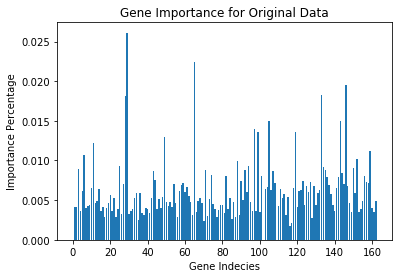

In [34]:
# Now to look at feature importance!
from matplotlib import pyplot
genes_og = model_OG.feature_importances_;
# print(model_OG.feature_importances_)
# plot
pyplot.bar(range(len(model_OG.feature_importances_)), model_OG.feature_importances_)
pyplot.ylabel('Importance Percentage')
pyplot.xlabel('Gene Indecies')
pyplot.title('Gene Importance for Original Data')
pyplot.savefig('OG_geneImportance.png',dpi=720)
pyplot.show()

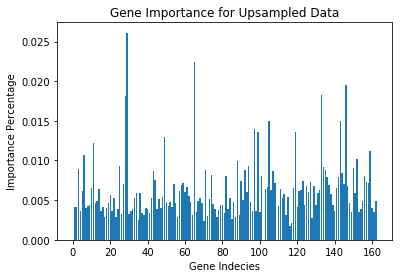

In [35]:
# Now to look at feature importance!
from matplotlib import pyplot
genes_upsampled = model_up.feature_importances_;
# print(model_up.feature_importances_)

# plot
pyplot.bar(range(len(model_up.feature_importances_)), model_up.feature_importances_)
pyplot.ylabel('Importance Percentage')
pyplot.xlabel('Gene Indecies')
pyplot.title('Gene Importance for Upsampled Data')
pyplot.savefig('UP_geneImportance.png',dpi=720)
pyplot.show()

These are good results! Specially that we can see that bootstrapping reduced the number of false positives!

We will also create a mapping between the index and the gene names, which will be useful later for studying feature importance and Gene Set Enrichment Analysis

In [36]:
top_100_genes_up = np.argsort(genes_upsampled)[-100:]
top_100_genes_og = np.argsort(genes_og)[-100:]
gene_weight_upsampled = np.take(genes_upsampled, top_100_genes_up, 0);


selected_genes = np.take(genes, top_100_genes_up, 0);
# print(selected_genes)
print(selected_genes)

['KIAA1524' 'ITGA6' 'AOX1' 'SH3PXD2B' 'NGFR' 'TPR' 'MROH2B' 'HBS1L' 'ILF2'
 'ATAD2B' 'DCST1' 'ATP1A3' 'ADSL' 'ATIC' 'COBLL1' 'ANKHD1-EIF4EBP3'
 'DOCK7' 'SPHKAP' 'LRP2' 'GATA3' 'CEP72' 'PTPRM' 'CRHR2' 'FAM74A1'
 'TMEM167B' 'PCGF5' 'NTPCR' 'ABT1' 'SLC25A16' 'ADAM10' 'ZNF587B'
 'C18orf54' 'MIR16-1' 'MRPL54' 'LINC00477' 'HLX' 'C6orf136' 'TTC39A'
 'BSCL2' 'SLC26A9' 'TATDN1' 'MEN1' 'SCFD1' 'PDZRN3' 'METTL2B' 'SEC16A'
 'OR52E4' 'RRN3P2' 'MAP4K4' 'PSEN2' 'POP1' 'CAND1' 'KIF1C' 'UBE4A' 'NSL1'
 'TRPM7' 'AARS' 'PHLDB1' 'TNR' 'CPXM1' 'CNTRL' 'KCTD3' 'ITGB7' 'ZNF547'
 'MALAT1' 'PRRC1' 'INSIG2' 'TTBK2' 'DOC2A' 'PTPN12' 'MAPK10' 'PRKD2'
 'CBLB' 'BCKDK' 'MUC2' 'CA9' 'POTEB3' 'CH17-140K24.8' 'CYP20A1' 'TNFRSF8'
 'ABCA7' 'FBLN5' 'ZBTB24' 'TAF3' 'ZFYVE16' 'MUC16' 'ROR1' 'RPRD1B'
 'ACVR2A' 'OLFML3' 'PKD1L1' 'OR5B2' 'WIPI2' 'ZFPM2' 'PRSS53' 'XRCC6BP1'
 'STRN3' 'ANKRD11' 'LONRF2' 'NT5DC3']


Now we save the list as a string array : 

In [37]:
gene_list = ['KIAA1524' 'ITGA6' 'AOX1' 'SH3PXD2B' 'NGFR' 'TPR' 'MROH2B' 'HBS1L' 'ILF2'
 'ATAD2B' 'DCST1' 'ATP1A3' 'ADSL' 'ATIC' 'COBLL1' 'ANKHD1-EIF4EBP3'
 'DOCK7' 'SPHKAP' 'LRP2' 'GATA3' 'CEP72' 'PTPRM' 'CRHR2' 'FAM74A1'
 'TMEM167B' 'PCGF5' 'NTPCR' 'ABT1' 'SLC25A16' 'ADAM10' 'ZNF587B'
 'C18orf54' 'MIR16-1' 'MRPL54' 'LINC00477' 'HLX' 'C6orf136' 'TTC39A'
 'BSCL2' 'SLC26A9' 'TATDN1' 'MEN1' 'SCFD1' 'PDZRN3' 'METTL2B' 'SEC16A'
 'OR52E4' 'RRN3P2' 'MAP4K4' 'PSEN2' 'POP1' 'CAND1' 'KIF1C' 'UBE4A' 'NSL1'
 'TRPM7' 'AARS' 'PHLDB1' 'TNR' 'CPXM1' 'CNTRL' 'KCTD3' 'ITGB7' 'ZNF547'
 'MALAT1' 'PRRC1' 'INSIG2' 'TTBK2' 'DOC2A' 'PTPN12' 'MAPK10' 'PRKD2'
 'CBLB' 'BCKDK' 'MUC2' 'CA9' 'POTEB3' 'CH17-140K24.8' 'CYP20A1' 'TNFRSF8'
 'ABCA7' 'FBLN5' 'ZBTB24' 'TAF3' 'ZFYVE16' 'MUC16' 'ROR1' 'RPRD1B'
 'ACVR2A' 'OLFML3' 'PKD1L1' 'OR5B2' 'WIPI2' 'ZFPM2' 'PRSS53' 'XRCC6BP1'
 'STRN3' 'ANKRD11' 'LONRF2' 'NT5DC3']

And to have a list of all the genes : 

In [38]:
for i in range(len(selected_genes)):
    print("{}".format(selected_genes[i]))

KIAA1524
ITGA6
AOX1
SH3PXD2B
NGFR
TPR
MROH2B
HBS1L
ILF2
ATAD2B
DCST1
ATP1A3
ADSL
ATIC
COBLL1
ANKHD1-EIF4EBP3
DOCK7
SPHKAP
LRP2
GATA3
CEP72
PTPRM
CRHR2
FAM74A1
TMEM167B
PCGF5
NTPCR
ABT1
SLC25A16
ADAM10
ZNF587B
C18orf54
MIR16-1
MRPL54
LINC00477
HLX
C6orf136
TTC39A
BSCL2
SLC26A9
TATDN1
MEN1
SCFD1
PDZRN3
METTL2B
SEC16A
OR52E4
RRN3P2
MAP4K4
PSEN2
POP1
CAND1
KIF1C
UBE4A
NSL1
TRPM7
AARS
PHLDB1
TNR
CPXM1
CNTRL
KCTD3
ITGB7
ZNF547
MALAT1
PRRC1
INSIG2
TTBK2
DOC2A
PTPN12
MAPK10
PRKD2
CBLB
BCKDK
MUC2
CA9
POTEB3
CH17-140K24.8
CYP20A1
TNFRSF8
ABCA7
FBLN5
ZBTB24
TAF3
ZFYVE16
MUC16
ROR1
RPRD1B
ACVR2A
OLFML3
PKD1L1
OR5B2
WIPI2
ZFPM2
PRSS53
XRCC6BP1
STRN3
ANKRD11
LONRF2
NT5DC3


# Gene Set Analysis
First we want to perform the gene set enrichment analysis. We must have a ranked list of genes in order to use GSEA, so we will use the feature importance as a ranking of the genes. In the next section we will use Enrichr, which does not require a ranked list.

In [39]:
# put the genes and weights in a dataframe
gene_weight = {'col1': selected_genes, 'col2': gene_weight_upsampled}
weights_df = pd.DataFrame(data=gene_weight)
weights_df.head(20)


,col1,col2
0,KIAA1524,0.004483
1,ITGA6,0.004588
2,AOX1,0.004598
3,SH3PXD2B,0.004638
4,NGFR,0.004662
5,TPR,0.004702
6,MROH2B,0.004724
7,HBS1L,0.004784
8,ILF2,0.004810
9,ATAD2B,0.004812


In [40]:
import gseapy as gp
# perform gsea in parallel (processes=-1) and save the results as png
pre_res = gp.prerank(rnk=weights_df, gene_sets='KEGG_2016',
                     processes=-1,
                     permutation_num=100,
                     min_size=3,# reduce number to speed up testing
                     outdir='GSEA/prerank_report_kegg', format='png')

In [41]:
from gseapy.plot import gseaplot
#display the results
pre_res.res2d.head(10)


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Metabolic pathways_Homo sapiens_hsa01100,-0.760417,-5.274617,0.000000,0.018223,1239,4,NTPCR;ATIC;ADSL;AOX1,NTPCR;ATIC;ADSL;AOX1
Purine metabolism_Homo sapiens_hsa00230,-0.752577,-4.353439,0.000000,0.200456,176,3,NTPCR;ATIC;ADSL,NTPCR;ATIC;ADSL
ECM-receptor interaction_Homo sapiens_hsa04512,-0.381443,-2.469769,0.727273,0.753227,82,3,ITGB7;TNR;ITGA6,ITGB7;TNR;ITGA6
Focal adhesion_Homo sapiens_hsa04510,0.423455,1.441106,0.683333,0.802453,202,4,MAPK10;ITGB7;TNR;ITGA6,MAPK10;ITGB7;TNR
Transcriptional misregulation in cancer_Homo sapiens_hsa05202,-0.381443,-2.070181,0.666667,0.859095,180,3,ITGB7;MEN1;NGFR,ITGB7;MEN1;NGFR
Mineral absorption_Homo sapiens_hsa04978,-0.453608,-2.520322,0.425000,0.874715,51,3,TRPM7;SLC26A9;ATP1A3,TRPM7;SLC26A9;ATP1A3
Pathways in cancer_Homo sapiens_hsa05200,0.343783,1.055386,0.838235,0.883049,397,4,CBLB;MAPK10;TPR;ITGA6,CBLB;MAPK10
Neurotrophin signaling pathway_Homo sapiens_hsa04722,-0.298969,-1.625421,0.875000,0.936219,120,3,MAPK10;PSEN2;NGFR,MAPK10;PSEN2;NGFR
Cytokine-cytokine receptor interaction_Homo sapiens_hsa04060,0.623684,1.886964,0.222222,0.967148,265,3,ACVR2A;TNFRSF8;NGFR,ACVR2A;TNFRSF8


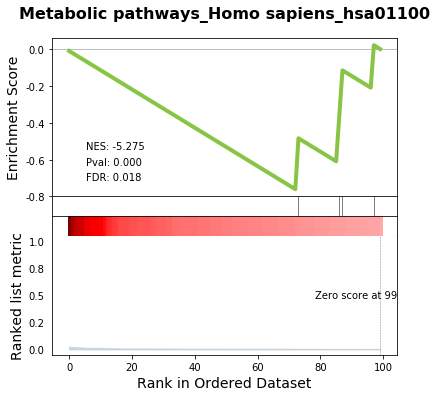

In [42]:
# display the smallest p-value
# we could check any of them with changing the index of the term
terms = pre_res.res2d.index
gseaplot(rank_metric=pre_res.ranking, term=terms[0], **pre_res.results[terms[0]])

here we print the list of available gene sets

In [43]:
# print out the available dataset
gp.get_library_name(database='Human')

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CORUM',
 'Cancer_Cell_Line_Encyclopedia',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'DisGeNET',
 'Disease_Perturbations_from_GEO_down',
 'Disease_Perturbations_from_GEO_up',
 'Disease_Signatures_from_GEO_down_2014',
 'Disease_Signatures_from_GEO_up_2014',
 'DrugMatrix',
 'Drug_Perturbations_from_GEO_2014',
 'Drug_Perturbations_from_GEO_down',
 'Drug_Perturbations_from_GEO_up',
 'EN

## Gene Set Analysis with Enrichr
We want to run an analysis that does not require a ranked list, so we will use Enrichr to run the test. We could also use the HTML interface on the web, which could be a lot more interactive and easier to interpret.

In [44]:

enr = gp.enrichr(gene_list=gene_list,
                 description='test_name',
                 gene_sets=['Cancer_Cell_Line_Encyclopedia','BioPlanet_2019','KEGG_2019_Human'],
                 outdir='test/enrichr_kegg',
                )



2019-12-19 07:10:40,964 Warning: No enrich terms using library Cancer_Cell_Line_Encyclopedia when cutoff = 0.05
2019-12-19 07:10:42,330 Warning: No enrich terms using library BioPlanet_2019 when cutoff = 0.05
2019-12-19 07:10:43,714 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


In [45]:
enr.results.head()

,Adjusted P-value,Combined Score,Gene_set,Genes,Odds Ratio,Old Adjusted P-value,Old P-value,Overlap,P-value,Term


Since we were not able to get comprehensive results using the python script, we will run the same gene list on the Enrichr website located [here](https://amp.pharm.mssm.edu/Enrichr/)